# CPSC 330 - Applied Machine Learning 

## Homework 3: Preprocessing 
### Associated lectures: [Lectures 4, 5, 6](https://ubc-cs.github.io/cpsc330/README.html) 

**Due date: Wednesday, Feb 01, 2023 at 11:59pm**

## Table of Contents

- [Instructions](#si)
- [Introduction](#in)
- [Exercise 1: Introducing the dataset](#1)
- [Exercise 2: Exploratory data analysis (EDA)](#2)
- [Exercise 3: Preprocessing](#3)
- [Exercise 4: Building models](#4)
- [Exercise 5: Evaluating on the test set](#5)

## Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Instructions <a name="si"></a>
<hr>
rubric={points:6}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work with a partner on this homework (maximum group size: 2).** 

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

## Introduction <a name="in"></a>
<hr>

A crucial step when using machine learning algorithms on real-world datasets is preprocessing. This homework will give you some practice of data preprocessing and building a supervised machine learning pipeline on a real-world dataset. 

<br><br>

## Exercise 1: Introducing the dataset <a name="1"></a>
<hr>

In this lab, you will be working on [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income#). Download the CSV and save it as `adult.csv` locally in this homework folder. 

This is a classification dataset and the classification task is to predict whether income exceeds 50K per year or not based on the census data. You can find more information on the dataset and features [here](http://archive.ics.uci.edu/ml/datasets/Adult).

The starter code below loads the data CSV (assuming that it is saved as `adult.csv` in this folder). 

_Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary._

In [2]:
census_df = pd.read_csv("./adult.csv")
census_df.shape

(32561, 15)

<br><br>

### 1.1 Data splitting 
rubric={points:4}

In order to avoid violation of the golden rule, the first step before we do anything is splitting the data. 

**Your tasks:**

1. Split the data into `train_df` (60%) and `test_df` (40%) with `random_state = 42`. Keep the target column (`income`) in the splits so that we can use it in the exploratory data analysis.  

_Usually having more data for training is a good idea. But here we're using a 60%/40% split because this is kind of a big dataset for a modest laptop. A smaller training set means that it won't take too long to train the model on your laptop. A side advantage of this would be that with a bigger test split, we'll have a more reliable estimate of the deployment performance!_

In [3]:
train_df, test_df = train_test_split(census_df, test_size=0.4, random_state=42)

<br><br>

## Exercise 2: Exploratory data analysis (EDA) <a name="2"></a> 
<hr>

Let's examine our `train_df`. 

In [ ]:
train_df.sort_index()

We see some missing values represented with a "?". Probably these were the questions not answered by some people during the census.  Usually `.describe()` or `.info()` methods would give you information on missing values. But here, they won't pick "?" as missing values as they are encoded as strings instead of an actual NaN in Python. So let's replace them with `np.nan` before we carry out EDA. If you do not do it, you'll encounter an error later on when you try to pass this data to a classifier. 

In [4]:
train_df_nan = train_df.replace("?", np.nan)
test_df_nan = test_df.replace("?", np.nan)
train_df_nan.shape

(19536, 15)

In [5]:
train_df_nan.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,NaN,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32553,43,Private,84661,Assoc-voc,11,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,<=50K
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32555,53,Private,321865,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K


The "?" symbols are now replaced with NaN values. 

<br><br>

### 2.1 Visualizing features
rubric={points:10}

**Your tasks:**

1. Examine the information given by `train_df_nan.info()` and `train_df_nan.describe()` methods. In case of `.describe()`, use the `include="all"` argument to show summary statistics of all  features.
2. Visualize the histograms of numeric features. 
3. From the visualizations, which features seem relevant for the given prediction task?

> Note: (Optional) If you're feeling excited about this you are welcome to use [`pandas_profiling`](https://github.com/pandas-profiling/pandas-profiling) for more elaborate visualization and EDA. 

In [6]:
train_df_nan.describe(include="all")

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
count,19536.000000,18428,1.953600e+04,19536,19536.000000,19536,18424,19536,19536,19536,19536.000000,19536.000000,19536.000000,19187,19536
unique,NaN,8,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,41,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,13570,NaN,6256,NaN,9025,2490,7937,16676,13079,NaN,NaN,NaN,17517,14841
mean,38.592547,NaN,1.892662e+05,NaN,10.084767,NaN,NaN,NaN,NaN,NaN,1090.443540,86.537162,40.532606,NaN,NaN
std,13.638971,NaN,1.049020e+05,NaN,2.580723,NaN,NaN,NaN,NaN,NaN,7449.700833,402.395668,12.406636,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.177670e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.782835e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,47.000000,NaN,2.368860e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [7]:
train_df_nan.info

<bound method DataFrame.info of        age    workclass  fnlwgt     education  education.num  \
25823   36      Private  245521       7th-8th              4   
10274   26      Private  134287     Assoc-voc             11   
27652   25    Local-gov  109526       HS-grad              9   
13941   23      Private  131275       HS-grad              9   
31384   27      Private  193122       HS-grad              9   
...    ...          ...     ...           ...            ...   
29802   25      Private  410240       HS-grad              9   
5390    51      Private  146767     Assoc-voc             11   
860     55  Federal-gov  238192       HS-grad              9   
15795   41      Private  154076  Some-college             10   
23654   22      Private  162667       HS-grad              9   

           marital.status         occupation relationship                race  \
25823  Married-civ-spouse    Farming-fishing      Husband               White   
10274       Never-married            

array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'fnlwgt'}>],
       [<AxesSubplot: title={'center': 'education.num'}>,
        <AxesSubplot: title={'center': 'capital.gain'}>],
       [<AxesSubplot: title={'center': 'capital.loss'}>,
        <AxesSubplot: title={'center': 'hours.per.week'}>]], dtype=object)

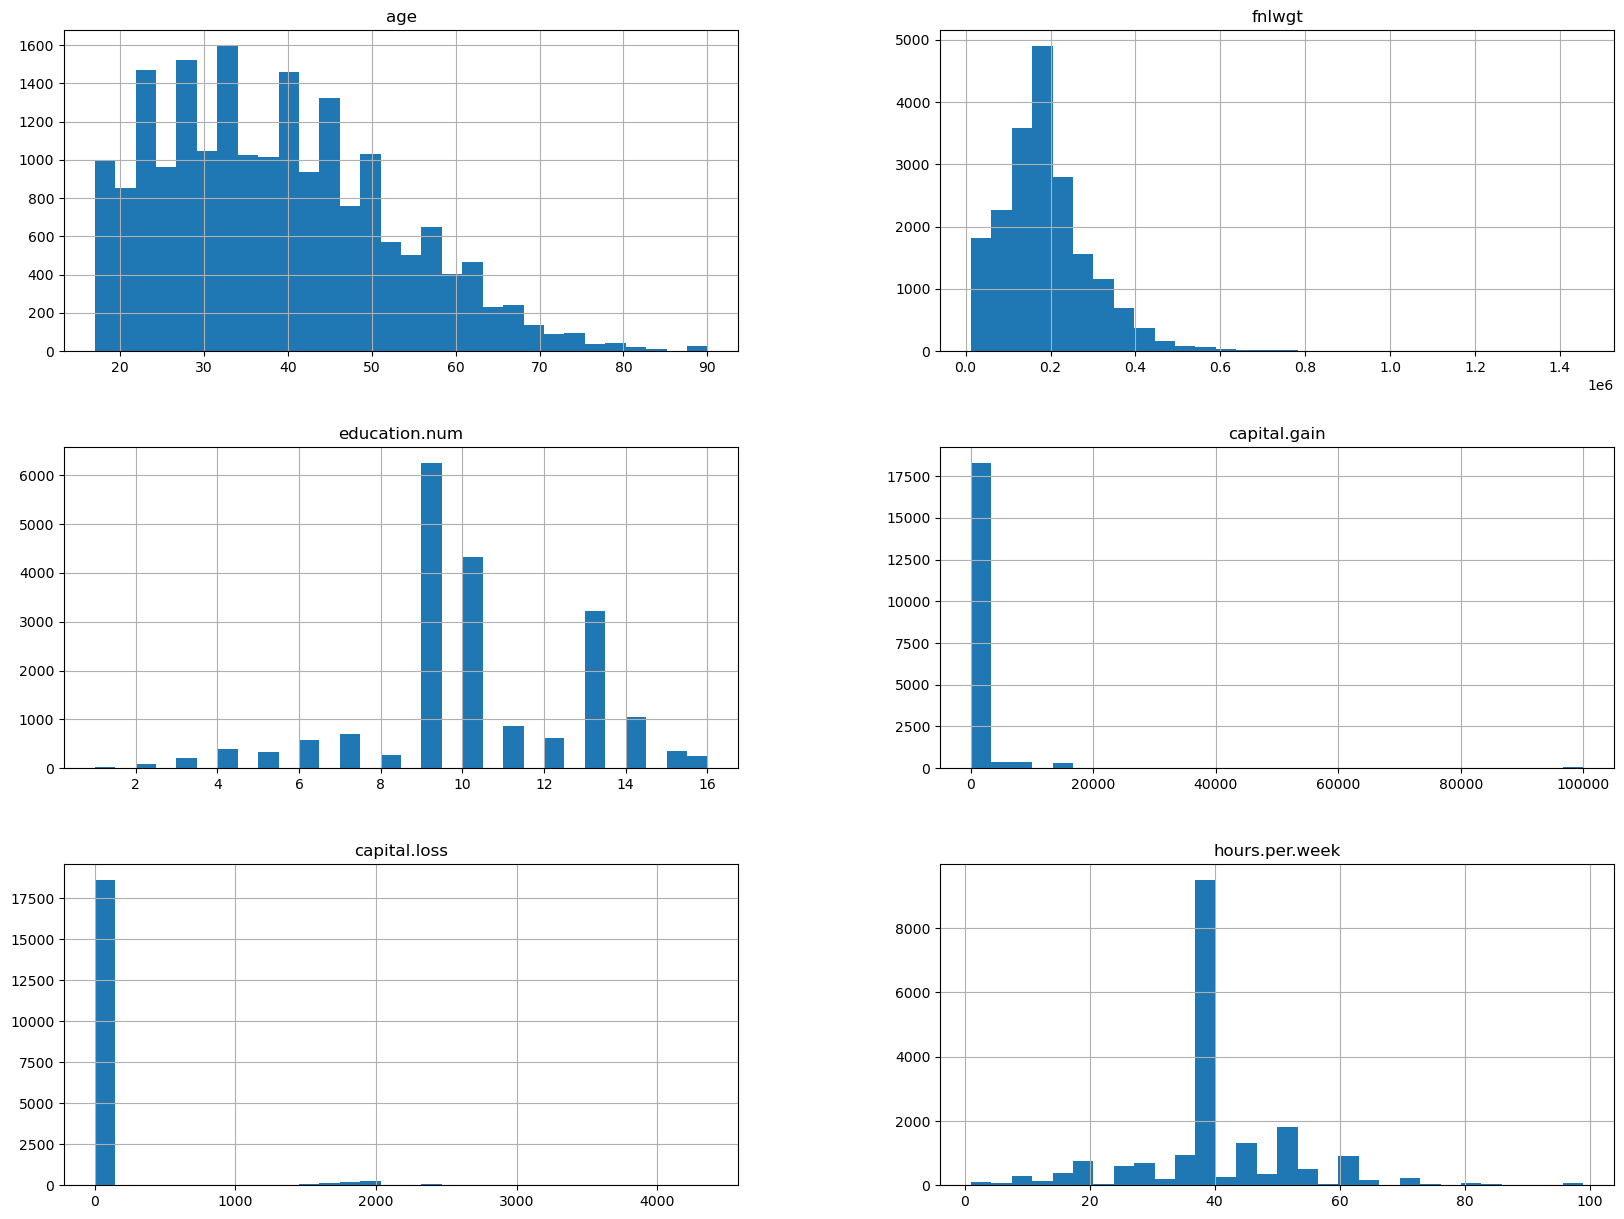

In [8]:
train_df_nan.hist(bins=30, figsize=(20, 15))

**ANS:** After analyzing the visualization of the numeric features and the summary statistics, I feel that all the features are relevant in order to predict the income.

<br><br>

### 2.2 Identify transformations to apply
rubric={points:18}

**Your tasks:**
1. Identify the sequence of transformations that you would apply on each column in the dataset and fill in the table below accordingly. An example of the sequence of transformations to be applied on the `occupation` feature is shown in the table below. You may decide not to apply any transformations on a certain column or entirely drop a column from your model. That's totally fine. 
2. Are there common transformations you would like to apply on certain types of features? Identify different feature types for applying different transformations. In particular, fill in the lists below. 
3. Is including the `race` feature for predicting income ethically a good idea? Briefly discuss. 

> Note: This question is a bit open-ended and there is no single correct solution.

| Feature | Transformation |
| --- | ----------- |
| occupation | imputation, OHE |
| age | scale |
| workclass | imputation, OHE |
| fnlwgt | scale |
| education |  |
| education.num | scale |
| marital.status | OHE |
| relationship | OHE |
| race | OHE |
| sex | OHE |
| capital.gain | scale |
| capital.loss | scale |
| hours.per.week | scale |
| native.country | imputation, OHE |


In [23]:
# Fill in the lists below. 
# It's OK to keep some of the lists empty or add new lists. 
numeric_features = ["age", "fnlwgt", "education.num", "capital.gain", "capital.loss", "hours.per.week"] # scaling
categorical_features = ["workclass", "marital.status", "occupation", "relationship", "race", "native.country", "sex"] # OHE
ordinal_features = []
binary_features = ["sex"] # OHE
drop_features = ["education"] # drop since education.num is the numerical representation, so this would be duplicated data
passthrough_features = []
target = "income"

**ANS:** Ethically, I believe that race as a feature is not racist or incorrect, depending on how the data is interpreted. If it can be proven that race does affect the prediction with a high correlation, this is a completely valid feature that would affect the model. As long as we don't interpret this form of data with malicious intent or judgment and rather see it as scientific data, I believe it is ethical.

<br><br>

### 2.3 Separating feature vectors and targets  
rubric={points:4}

**Your tasks:**

1. Create `X_train`, `y_train`, `X_test`, `y_test` from `train_df_nan` and `test_df_nan`. 
2. At this point, if you train [`sklearn`'s `SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model on `X_train` and `y_train` would it work? Why or why not?

In [11]:
X_train, y_train = train_df_nan.drop(columns=[target]), train_df_nan[target]
X_test, y_test = test_df_nan.drop(columns=[target]), test_df_nan[target]

It would not work, since you may be violating the golden rule and leaking some of the valid data into the train step

<br><br><br><br>

## Exercise 3: Preprocessing <a name="3"></a>
<hr>

### 3.1 Preprocessing using `sklearn`'s `ColumnTransformer` and `Pipeline`
rubric={points:18}

Let's carry out preprocessing using `sklearn`'s `ColumnTransformer` and `Pipeline`. Note that you can define pipelines in two ways: 
- by using [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and explicitly providing named steps
- by using [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline), which automatically names the steps in the pipeline with their class names. 

Similarly you can create a column transformer in two ways:
- by using [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
- by using [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) 

You may use the method of your choice but `make_pipeline` and `make_column_transformer` are highly recommended.  

**Your tasks:**

1. Create a column transformer `preprocessor` based on transformations you want to apply on the data from 2.2. 
2. Transform the data by calling `fit_transform` on the training set. What's the shape of the transformed data? 
3. Why do we need to use a column transformer in this case? Briefly explain. 

In [18]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    ("passthrough", passthrough_features),
    (
        make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop="if_binary", sparse=False)),
        categorical_features,
    ),
    ("drop", drop_features),
)

transformed = preprocessor.fit_transform(X_train)

column_names = numeric_features + passthrough_features + list(
    preprocessor.named_transformers_["pipeline"]["onehotencoder"].get_feature_names_out(
        categorical_features
    )
)

pd.DataFrame(transformed, columns=column_names)


,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia,sex_Male
0,-0.190089,0.536275,-2.357837,-0.146378,-0.215060,-0.445951,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.923301,-0.524114,0.354651,-0.146378,-0.215060,-0.445951,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.996622,-0.760159,-0.420345,-0.146378,-0.215060,-0.204138,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-1.143264,-0.552827,-0.420345,-0.146378,-0.215060,-0.042930,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,-0.849979,0.036757,-0.420345,-0.146378,-0.215060,-0.042930,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19531,-0.996622,2.106533,-0.420345,-0.146378,-0.215060,-0.042930,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
19532,0.909729,-0.405142,0.354651,-0.146378,-0.215060,-0.042930,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
19533,1.203014,0.466408,-0.420345,-0.146378,4.474474,-0.042930,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
19534,0.176517,-0.335466,-0.032847,-0.146378,-0.215060,0.763111,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


**ANS:** the shape of the data has 19536 rows, same as before, but now 88 columns instead of the 15 before. This is due to the one-hot encoding, where multiple binary columns were generated for each category. There are also no more NaN values, and the data is all scaled accordingly

**ANS:** We need a column transformer as we have to apply different preprocessing methods to different columns. For example, we do not need to scale the categorical values, and would rather apply different transforming methods such as the imputation and one hot encoder as shown above. By using a column transformer, this allows us to select which methods we'd like for each specific column to prepare our data sufficiently.

<br><br><br><br>

## Exercise 4: Building models <a name="4"></a>
<hr>

Now that we have preprocessed features, we are ready to build models. Below is the function we used in class, which returns the mean cross-validation score along with standard deviation for a given model. Feel free to use it to keep track of your results if you like. 

In [20]:
results_dict = {} # dictionary to store all the results

In [21]:

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<br><br>

### 4.1 Baseline model 
rubric={points:6}

**Your tasks:**
1. Define a pipeline with two steps: `preprocessor` from 3.1 and `scikit-learn`'s `DummyClassifier` with `strategy="prior"` as your classifier.  
2. Carry out 5-fold cross-validation with the pipeline. Store the results in `results_dict` above. Display the results as a pandas DataFrame.  

> You may use the function `mean_std_cross_val_scores` above to carry out cross-validation and storing results. Refer to the class notes if you are unsure about how to use it. 

In [37]:
pipe_dummy = make_pipeline(
    preprocessor, DummyClassifier(strategy="prior"),
)

results_dict["dummy"] = mean_std_cross_val_scores(
    pipe_dummy, X_train, y_train, return_train_score=True, cv=5, 
)
pd.DataFrame(results_dict)

C:\Users\Michelle Wang\miniconda3\envs\cpsc330\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Michelle Wang\miniconda3\envs\cpsc330\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Michelle Wang\miniconda3\envs\cpsc330\lib\site-packages\sklearn\metrics\_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Michelle Wang\miniconda3\envs\cpsc330\lib\site-packages\sklearn\pipeline.py", line 695, in score
    Xt = transform.transform(Xt)
  File "C:\Users\Michelle Wang\miniconda3\envs\cpsc330\lib\site-packages\sklearn\compose\_column_transformer.py", line 763, in transform
    Xs = self._fit_transform(
  File "C:\Users\Michelle Wang\miniconda3\envs\cpsc330\lib\site

,preprocessed + dummy,preprocessed + decision tree,dummy,decision tree,kNN,RBF SVM
fit_time,0.056 (+/- 0.010),0.169 (+/- 0.018),0.453 (+/- 0.260),0.176 (+/- 0.009),0.063 (+/- 0.009),18.480 (+/- 2.527)
score_time,0.016 (+/- 0.005),0.014 (+/- 0.008),0.142 (+/- 0.082),0.016 (+/- 0.002),0.294 (+/- 0.191),5.024 (+/- 3.532)
test_score,0.760 (+/- 0.000),0.814 (+/- 0.002),0.760 (+/- 0.000),0.817 (+/- 0.003),0.833 (+/- 0.003),0.854 (+/- 0.005)
train_score,0.760 (+/- 0.000),1.000 (+/- 0.000),0.760 (+/- 0.000),1.000 (+/- 0.000),0.882 (+/- 0.001),0.867 (+/- 0.002)


<br><br>

### 4.2 Trying different classifiers
rubric={points:14}

**Your tasks:**

1. For each of the models in the starter code below: 
    - Define a pipeline with two steps: `preprocessor` from 3.1 and the model as your classifier. 
    - Carry out 5-fold cross-validation with the pipeline.  
    - Store the results in `results_dict`. 
2. Display all the results so far as a pandas dataframe. 
3. Compare the train and validation accuracies and `fit` and `score` times in each case. How do the the validation accuracies compare to the baseline model from 4.1? Which model has the best validation accuracy? Which model is the fastest one?  

> Note that this might take a while to run.

> You may use the function above `mean_std_cross_val_scores` to carry out cross-validation and storing results. Refer to the class notes if you are unsure about how to use it. 

In [39]:
models = {
    "decision tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(),
}

# decision tree
pipe_tree = make_pipeline(
    preprocessor, models["decision tree"],
)

results_dict["decision tree"] = mean_std_cross_val_scores(
    pipe_tree, X_train, y_train, return_train_score=True, cv=5, 
)

# kNN
pipe_knn = make_pipeline(
    preprocessor, models["kNN"],
)

results_dict["kNN"] = mean_std_cross_val_scores(
    pipe_knn, X_train, y_train, return_train_score=True, cv=5, 
)

# RBF SVM
pipe_svm = make_pipeline(
    preprocessor, models["RBF SVM"],
)

results_dict["RBF SVM"] = mean_std_cross_val_scores(
    pipe_svm, X_train, y_train, return_train_score=True, cv=5, 
)

pd.DataFrame(results_dict)

C:\Users\Michelle Wang\miniconda3\envs\cpsc330\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Michelle Wang\miniconda3\envs\cpsc330\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Michelle Wang\miniconda3\envs\cpsc330\lib\site-packages\sklearn\metrics\_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Michelle Wang\miniconda3\envs\cpsc330\lib\site-packages\sklearn\pipeline.py", line 695, in score
    Xt = transform.transform(Xt)
  File "C:\Users\Michelle Wang\miniconda3\envs\cpsc330\lib\site-packages\sklearn\compose\_column_transformer.py", line 763, in transform
    Xs = self._fit_transform(
  File "C:\Users\Michelle Wang\miniconda3\envs\cpsc330\lib\site

,preprocessed + dummy,preprocessed + decision tree,dummy,decision tree,kNN,RBF SVM
fit_time,0.056 (+/- 0.010),0.169 (+/- 0.018),0.453 (+/- 0.260),0.902 (+/- 0.986),0.061 (+/- 0.001),11.677 (+/- 2.910)
score_time,0.016 (+/- 0.005),0.014 (+/- 0.008),0.142 (+/- 0.082),0.064 (+/- 0.076),0.261 (+/- 0.150),2.269 (+/- 1.271)
test_score,0.760 (+/- 0.000),0.814 (+/- 0.002),0.760 (+/- 0.000),0.814 (+/- 0.002),0.833 (+/- 0.003),0.854 (+/- 0.005)
train_score,0.760 (+/- 0.000),1.000 (+/- 0.000),0.760 (+/- 0.000),1.000 (+/- 0.000),0.882 (+/- 0.001),0.867 (+/- 0.002)


Compare the train and validation accuracies and fit and score times in each case. How do the the validation accuracies compare to the baseline model from 4.1? Which model has the best validation accuracy? Which model is the fastest one?

**ANS:** The validation and train accuracies increase for each model. The baseline model gives a validation accuracy of 0.760, with the next highest validation scores as decision tree (0.814), kNN (0.833) and the best with RBF SVM (0.867). This assures us that the models are improving the accuracy and we are performing relevant applications. The corresponding training scores also become closer to the increasing validation scores with each model. Although RBF SVM has the best validation accuracy, it also has the longest fit and score times by far. The fastest model would be the kNN model. 

<br><br>

### (optional) 4.3 Exploring the importance of scaling
rubric={points:1}

In this exercise you'll examine whether scaling helps in case of KNNs and SVM RBFs. 

**Your tasks:**

1. Create a column transformer without the `StandardScaler` step for `numeric_features`. 
2. Repeat the steps in 4.2 with this new column transformer. 
3. Compare the results of scaled numeric features with unscaled numeric features. Is scaling necessary for decision trees? Why or why not?

In [41]:
pre_no_scaling = make_column_transformer(
    ("passthrough", passthrough_features),
    (
        make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop="if_binary", sparse=False)),
        categorical_features,
    ),
    ("drop", drop_features),
)

# decision tree
pipe_tree_no_scaling = make_pipeline(
    pre_no_scaling, models["decision tree"],
)

results_dict["decision tree + no scaling"] = mean_std_cross_val_scores(
    pipe_tree_no_scaling, X_train, y_train, return_train_score=True, cv=5, 
)

# kNN
pipe_knn_no_scaling = make_pipeline(
    pre_no_scaling, models["kNN"],
)

results_dict["kNN + no scaling"] = mean_std_cross_val_scores(
    pipe_knn_no_scaling, X_train, y_train, return_train_score=True, cv=5, 
)

# RBF SVM
pipe_svm_no_scaling = make_pipeline(
    pre_no_scaling, models["RBF SVM"],
)

results_dict["RBF SVM + no scaling"] = mean_std_cross_val_scores(
    pipe_svm_no_scaling, X_train, y_train, return_train_score=True, cv=5, 
)

pd.DataFrame(results_dict)

C:\Users\Michelle Wang\miniconda3\envs\cpsc330\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Michelle Wang\miniconda3\envs\cpsc330\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Michelle Wang\miniconda3\envs\cpsc330\lib\site-packages\sklearn\metrics\_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\Michelle Wang\miniconda3\envs\cpsc330\lib\site-packages\sklearn\pipeline.py", line 695, in score
    Xt = transform.transform(Xt)
  File "C:\Users\Michelle Wang\miniconda3\envs\cpsc330\lib\site-packages\sklearn\compose\_column_transformer.py", line 763, in transform
    Xs = self._fit_transform(
  File "C:\Users\Michelle Wang\miniconda3\envs\cpsc330\lib\site

,preprocessed + dummy,preprocessed + decision tree,dummy,decision tree,kNN,RBF SVM,decision tree + no scaling,kNN + no scaling,RBF SVM + no scaling
fit_time,0.056 (+/- 0.010),0.169 (+/- 0.018),0.453 (+/- 0.260),0.902 (+/- 0.986),0.061 (+/- 0.001),11.677 (+/- 2.910),0.124 (+/- 0.005),0.056 (+/- 0.010),13.561 (+/- 2.625)
score_time,0.016 (+/- 0.005),0.014 (+/- 0.008),0.142 (+/- 0.082),0.064 (+/- 0.076),0.261 (+/- 0.150),2.269 (+/- 1.271),0.022 (+/- 0.013),0.518 (+/- 0.628),2.865 (+/- 1.552)
test_score,0.760 (+/- 0.000),0.814 (+/- 0.002),0.760 (+/- 0.000),0.814 (+/- 0.002),0.833 (+/- 0.003),0.854 (+/- 0.005),0.807 (+/- 0.007),0.786 (+/- 0.002),0.817 (+/- 0.006)
train_score,0.760 (+/- 0.000),1.000 (+/- 0.000),0.760 (+/- 0.000),1.000 (+/- 0.000),0.882 (+/- 0.001),0.867 (+/- 0.002),0.838 (+/- 0.003),0.802 (+/- 0.006),0.822 (+/- 0.004)


**ANS:** The validation accuracies for the non scaled data are much lower compared to the scaled data. For kNN and RBF SVM, this resulted in a decreased score of (0.833 - 0.786 = 0.047) and (0.854 - 0.817 = 0.037). For the decision tree, the difference was less at (0.814 - 0.807 = 0.007). This shows that scaling is not necessary for decision trees since decision trees only deal with one feature at a time. This means that it doesn't need to account for scaling as the feature is not compared to other features that may be set at a different scale. 

### 4.4 Hyperparameter optimization
rubric={points:10}

In this exercise, you'll carry out hyperparameter optimization for the hyperparameter `C` of SVC RBF classifier. In practice you'll carry out hyperparameter optimization for all different hyperparameters for the most promising classifiers. For the purpose of this assignment, we'll only do it for the `SVC` classifier with one hyperparameter: `C`. 

**Your tasks:**

1. For each `C` value in the `param_grid` in the starter code below: 
    - Create a pipeline object with two steps: preprocessor from 3.1 and `SVC` classifier with the value of `C`.
    - Carry out 5-fold cross validation with the pipeline.  
    - Store the results in `results_dict` and display results as a pandas DataFrame. 
2. Which hyperparameter value seems to be performing the best, and why? Is it different than the default value for the hyperparameter used by `scikit-learn`? 

> Note: Running this might take a while. 

In [ ]:
param_vals = np.logspace(-2, 2, num=5, base=10)
param_grid = {"C": np.delete(param_vals, np.where(param_vals == 1.0))}

for c in param_grid["C"]:
    c_pipe = make_pipeline(
        preprocessor, SVC(C=c)
    )
    
    results_dict["SVC C = " + f"c"] = mean_std_cross_val_scores(
        c_pipe, X_train, y_train, return_train_score=True, cv=5, 
    )
    
pd.DataFrame(results_dict)

Which hyperparameter value seems to be performing the best, and why? Is it different than the default value for the hyperparameter used by scikit-learn?

**ANS:** The higher the value of c, the better the hyperparameter and validation score seems to be. This is because C controls how complex the model is, and a greater C results in a more accurate score. The values for C here are different from the default value for the hyperparameter from scikit learn which is C=1.0. They vary from less to more complex. 

<br><br><br><br>

## Exercise 5: Evaluating on the test set <a name="5"></a>
<hr>

Now that we have a best performing model, it's time to assess our model on the set aside test set. In this exercise you'll examine whether the results you obtained using cross-validation on the train set are consistent with the results on the test set. 

### 5.1 Scoring on the unseen test set 
rubric={points:10}

**Your tasks:**

1. Train the best performing model on the entire training set. 
2. Report the results of this model on `X_test`. 
3. Are the cross-validation results and test results consistent? 

In [ ]:
model_pipe = make_pipeline(
    preprocessor, SVC(C=100)
)

model_pipe.fit(X_train, y_train)
print(f"test score: {model_pipe.score(X_test, y_test)}")

**ANS:** The cross-validation results and test results are somewhat similar

## Exercise 6: Summary

rubric={Pass/Fail}

You are all done with Homework 3! Your last task is reflecting on what you have learned and answering the following questions. **This task is necessary to pass HW3**. Failing to complete this task means you will not receive points for this assignment.

1. In about 100 words, describe what you have learned from this homework.
2. Write at least one well-formulated question on something that is still not clear about the content of this homework, or you would like to know more about.

**ANS:** 
1. I learned about the importance of preprocessing and the different ways that you can prepare data. I learned how to analyze a dataset to determine what processing to perform, then how to choose between different methods such as OHE vs Ordinal Encoder. I also learned how to carry out these transformations and incorporate pipelines to preserve the golden rule. I then learned how to evaluate different models and apply cross-validation, as well as choosing between hyperparameters to determine the most accurate model. I evaluated these models based on their validation score and fit/model time. It was extremely rewarding to apply my theory into practice on real data.

2. I would like to know more methods for determining when it is appropriate to drop a feature. 

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 

This was a tricky one but I hope you are feeling good after working on it. You are now ready to build a simple supervised machine learning pipeline on real-world datasets! Well done (**and don't forget to submit**)! 

![](./eva-well-done.png)

